# Classify Pollen and Non-Pollen Bees
This image dataset has been created from videos captured at the entrance of a bee colony in June 2017 at the Bee facility of the Gurabo Agricultural Experimental Station of the University of Puerto Rico.

- `data/` contains images for pollen bearing and no pollen bearing honey bees.
    - The prefix of the images names define their class: e.g. `NP1268-15r.jpg` for non-pollen and `P7797-103r.jpg` for pollen bearing bees. The numbers correspond to frame and item number respectively, you need to be careful that they are not numbered sequentially.

## 1. Import required packages

In [1]:
# Import required modules/methods
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.
C:\Users\Vihan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Vihan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Vihan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Vihan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## 2. Prepare Data

In [3]:
df = pd.DataFrame(columns=["image_name","label"])
df.shape

(0, 2)

In [4]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="./data/P52248-14r.jpg", width=200, height=200)

In [5]:
IMAGE_DIR = "./data/"
# for i, img in enumerate(os.listdir("./data/")):
#     print(i, img)

In [6]:
# Create the dataframe of image names and labels
for index, image in enumerate(os.listdir(IMAGE_DIR)):
    if image.startswith("P"):
        df.loc[index,"image_name"] = image
        df.loc[index,"label"] = "POLLEN"
    elif image.startswith("N"):
        df.loc[index] = [image,"NO POLLEN"]
df[1:5]

,image_name,label
1,NP10109-128r.jpg,NO POLLEN
2,NP10154-130r.jpg,NO POLLEN
3,NP10304-132r.jpg,NO POLLEN
4,NP1034-9r.jpg,NO POLLEN


In [7]:
# Scale the data - [0,1], validation split - creating objects
train_DataGenerator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

test_DataGenerator = ImageDataGenerator(
    rescale=1/255,
)

In [8]:
# Split train and test datasets
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     shuffle=True, 
                                     random_state=1)

In [9]:
# Create train, test and validation datasets
# It does scaling, resizing the image to 128x128
train_images = train_DataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_name",
    y_col="label",
    directory = IMAGE_DIR,
    target_size=(128, 128),
    class_mode="binary",
    seed=42,
    subset='training'
)

val_images = train_DataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_name",
    y_col="label",
    directory = IMAGE_DIR,
    target_size=(128, 128),
    class_mode="binary",
    seed=42,
    subset='validation'
)

test_images = test_DataGenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_name",
    y_col="label",
    directory = IMAGE_DIR,
    target_size=(128, 128),
    class_mode="binary"
)

Found 457 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.


In [47]:
test_images.image_shape, train_images.image_shape

((128, 128, 3), (128, 128, 3))

## 3. Create CNN architecture

In [10]:
# Create a Sqequntial model object
model = Sequential()

# Add first Conv and pool layers
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 activation = "relu", 
                 input_shape = (128, 128, 3),
                 name= "Input_Layer"))
model.add(MaxPool2D((2,2), name = "Pooling_1"))

# 2nd Conv and pool layers
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 activation = "relu", 
                 name= "Conv_Layer"))
model.add(MaxPool2D((2,2), name = "Pooling_2"))

# Flatten the output of 2nd conv layer
model.add(Flatten())

# Add FC layers
model.add(Dense(128, activation="relu", name="Dense_1")) # FC1
model.add(Dense(64, activation="relu", name="Dense_2")) # FC2
model.add(Dense(2, activation="softmax", name="Output_Layer")) # FC3 - Output FC layer

In [11]:
# Print the details of CNN layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Conv2D)         (None, 126, 126, 32)      896       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 63, 63, 32)        0         
_________________________________________________________________
Conv_Layer (Conv2D)          (None, 61, 61, 32)        9248      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               3686528   
_________________________________________________________________
Dense_2 (Dense)              (None, 64)               

## 4. Compile the model

In [13]:
# Use sparse_categorical_crossentropy since there are only two labels/classes
# Otherwise we have to use sigmoid activation in the last dense layer with 1 neuron
# because sigmoid returns only one output. And, use binary_crossentropy as the loss function 
# in compile method.
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # Since there are only two classes
    metrics=["accuracy"]
)

## 5. Train the Model

In [16]:
# Build/Train the model using CNN
bee_model = model.fit(
    train_images,
    epochs = 20,
    validation_data=val_images
)

Epoch 1/20
15/15 [==============================] - 5s 355ms/step - loss: 0.3437 - accuracy: 0.8556 - val_loss: 0.3616 - val_accuracy: 0.8246
Epoch 2/20
15/15 [==============================] - 5s 357ms/step - loss: 0.2950 - accuracy: 0.8512 - val_loss: 0.2162 - val_accuracy: 0.8070
Epoch 3/20
15/15 [==============================] - 5s 352ms/step - loss: 0.2061 - accuracy: 0.9168 - val_loss: 0.2028 - val_accuracy: 0.8684
Epoch 4/20
15/15 [==============================] - 6s 375ms/step - loss: 0.1572 - accuracy: 0.9431 - val_loss: 0.1065 - val_accuracy: 0.8947
Epoch 5/20
15/15 [==============================] - 5s 355ms/step - loss: 0.1261 - accuracy: 0.9497 - val_loss: 0.1868 - val_accuracy: 0.8860
Epoch 6/20
15/15 [==============================] - 5s 352ms/step - loss: 0.1420 - accuracy: 0.9497 - val_loss: 0.3677 - val_accuracy: 0.8860
Epoch 7/20
15/15 [==============================] - 5s 354ms/step - loss: 0.0811 - accuracy: 0.9803 - val_loss: 0.3673 - val_accuracy: 0.8860
Epoch 

In [16]:
#bee_model.history.keys()

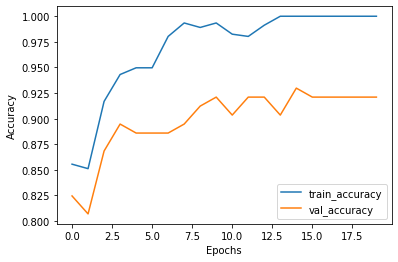

In [17]:
# Plot the accuracy curve
plt.plot(bee_model.history['accuracy'], label="train_accuracy")
plt.plot(bee_model.history['val_accuracy'], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

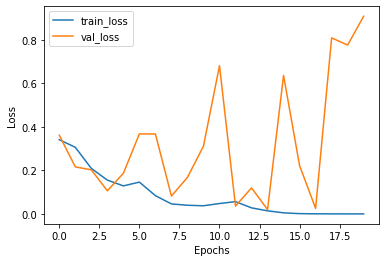

In [24]:
# Plot the loss curve
plt.plot(bee_model.history['loss'], label="train_loss")
plt.plot(bee_model.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# Save your model into a directory
model.save("./models/cnn_model.h5")

## 6. Evaluate the model

In [20]:
# Evaluate the model on test data - Get binary corss entropy loss and accuracy
model.evaluate(test_images)

5/5 [==============================] - 1s 257ms/step


[0.2234397530555725, 0.9020978808403015]

In [21]:
# We get the probablities of both classes for every test image
prediction_pobabilities = model.predict(test_images)

# Index 0 - Class0, Index 1 - Class 1
# Allot the class with max probability
# If calss 0 has max probablity then class=0 otherwise class=1

test_predictions = [np.argmax(prob) for prob in prediction_pobabilities]
test_predictions[1:5]

[0, 1, 1, 1]

In [22]:
cm = confusion_matrix(test_images.labels, test_predictions)
cm

array([[29, 39],
       [33, 42]], dtype=int64)

In [70]:
# Visulize confusion matrix-not required
# plt.figure(dpi=70)
# sns.heatmap(cm, annot=True, cmap="Blues")
# plt.xticks(ticks=[0.5,1.5], labels=['NO POLLEN', 'POLLEN'])
# plt.yticks(ticks=[0.5,1.5], labels=['NO POLLEN', 'POLLEN'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

In [23]:
# Print classification report - important for evaluation of the model
print(classification_report(test_images.labels, test_predictions))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45        68
           1       0.52      0.56      0.54        75

    accuracy                           0.50       143
   macro avg       0.49      0.49      0.49       143
weighted avg       0.49      0.50      0.49       143

